# Exploración de los Datos

### 1. Descripción general de los datos

La base de datos se encuentra disponible por el Instituto Nacional de Estadística y Geografía (INEGI) y para este análisis accedemos a la información de 2021, un análisis preliminar del diccionario de datos (https://www.inegi.org.mx/rnm/index.php/catalog/788/data-dictionary/F1?file_name=ATU) permite identifica un total de 46 variables, y algunas características principales de las variables como:

- La variable a predecir del conjunto de esta basada en la variable 'CLASACC', la cual describe un accidente como 'Fatal' o 'No Fatal.
- Algunas de las variables no son objeto de caso de estudio como 'FOLIO', que es de uso institucional
- Variables predictoras como Mes, Año, Hora, Minutos y Día las cuales describen cronológicamente el periodo en que ocurrió el accidente, 
- Localidad, Municipio, Urbana y suburbana la cual nos da a conocer la información del lugar donde ocurrió del accidente. 

- 'TIPACCID’, 'URBANA' y 'SUBURBANA' las cuales categorizan el lugar del accidente. 

- Sexo, Aliento, Cinturón y edad, las cuales brindan información sobre el conductor

- 14 Variables con tipos de vehículos las cuales permiten identificar el número de vehículos relacionados al accidente según su clase.


## Carga y Transformación de los Datos

### 2. Carga de los datos

Cargamos las librerías a utilizar

In [1]:
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams
#from pygam import LogisticGAM
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from collections import Counter

Cargamos los datos descargados en formato csv a una dataframe. 'atus_anual_2021.csv' contiene el registro de accidentes de transito para el 2021, mientras que 'inafed_bd_1679023638.xlsx' contiene los datos de los estados y municipalidades de todo México.

In [21]:
#### Utilicen este espacio para escribir los códigos del procedimiento del punto 1 ####
# Lectura de los datos
df_initial = pd.read_csv('atus_anual_2021.csv', index_col=False)
df_poblacion = pd.read_excel('inafed_bd_1679023638.xlsx', index_col=False)

df_initial_D = df_initial.copy()
df_poblacion_D = df_poblacion.copy()
df_initial.head(2)

,COBERTURA,ID_ENTIDAD,ID_MUNICIPIO,ANIO,MES,ID_HORA,ID_MINUTO,ID_DIA,DIASEMANA,URBANA,...,PEATMUERTO,PEATHERIDO,CICLMUERTO,CICLHERIDO,OTROMUERTO,OTROHERIDO,NEMUERTO,NEHERIDO,CLASACC,ESTATUS
0,Municipal,1,1,2021,1,0,0,1,Viernes,Accidente en intersección,...,0,0,0,0,0,0,0,0,Sólo daños,Cifras Definitivas
1,Municipal,1,1,2021,1,0,0,1,Viernes,Accidente en intersección,...,0,0,0,0,0,0,0,0,Sólo daños,Cifras Definitivas


### 3. Transformación de los datos

Hacemos Join de las tablas de población y accidentes para clasificar por tipo de ciudad.

In [22]:
df_initial['Cve_inegi'] = df_initial['ID_ENTIDAD']*1000 + df_initial.ID_MUNICIPIO

In [47]:
df_initial_m = df_initial.merge(df_poblacion, on = 'Cve_inegi', how ='left')
df_initial_m.head(2)

C:\Users\crama\anaconda3\lib\site-packages\pandas\core\reshape\merge.py:1209: RuntimeWarning: invalid value encountered in cast
  if not (rk == rk.astype(lk.dtype))[~np.isnan(rk)].all():


,COBERTURA,ID_ENTIDAD,ID_MUNICIPIO,ANIO,MES,ID_HORA,ID_MINUTO,ID_DIA,DIASEMANA,URBANA,...,id,id_estado,id_municipio,Estado,Municipio,total,Hombres,Mujeres,Clasificacion,ID_Mun
0,Municipal,1,1,2021,1,0,0,1,Viernes,Accidente en intersección,...,1,1.0,1.0,Aguascalientes,Aguascalientes,948990.0,462073.0,486917.0,Ciudad Grande,1.0
1,Municipal,1,1,2021,1,0,0,1,Viernes,Accidente en intersección,...,1,1.0,1.0,Aguascalientes,Aguascalientes,948990.0,462073.0,486917.0,Ciudad Grande,1.0


Eliminamos variables que no ofrecen información relevante para el objeto de estudio como ID_Entidad que es la codificación del instituto y Anio ya que la información se conoce con antelación que es del año 2021. También eliminamos las variables que conceptualmente ofrecen información redundante.

In [49]:
df_initial_m = df_initial_m.drop(['ID_ENTIDAD','ANIO','ID_MINUTO','NEMUERTO','NEHERIDO','COBERTURA','ESTATUS','id','id_estado','id_municipio','Estado','Municipio',
                                 'total','Hombres','Mujeres','ID_Mun'],axis=1)

Las siguientes funciones nos ayudaran a limpiar la base de datos y realizar un análisis de calidad de los mismos.

In [2]:
def pareto_entry(_col,_df):
    cuenta = []
    unicos = []
    porcentaje = []
    for i in list(_df[_col].unique()):
        tempy = pd.DataFrame(_df[_col])
        cuenta.append(tempy[tempy[_col]==i].count()[0])
        unicos.append(i)
        porcentaje.append(round(tempy[tempy[_col]==i].count()[0]/len(_df),3)*100)
    
    pareto_df = pd.DataFrame(unicos, columns=[_col])
    pareto_df['Count'] = cuenta
    pareto_df['Percentage'] = porcentaje
    pareto_df = pareto_df.sort_values(by=['Count'], ascending=False)
    pareto_df['Cum_Percentage'] = round(100*(pareto_df['Count'].cumsum()/pareto_df['Count'].sum()),1)
    
    return pareto_df

def crear_calidad(_df):
    completitud = []
    for i in list(_df.columns):
        vacios = _df[(_df[i]=="")|(_df[i].isna())]
        count_vacios = vacios[i].count()
        medida = round((1-(count_vacios/len(_df)))*100)
        completitud.append([i,medida])
    
    calidad_df = pd.DataFrame(completitud, columns = ['Columna','Completitud de Col(%)'])
    unicidad=[]
    distintivo=[]
    type_col = []
    Moda= []
    for j in list(_df.columns):
        unico = len(_df[_df[j].duplicated()==False])
        temp_df = _df[_df[j].duplicated()==True]
        distinto = len(temp_df[j].unique())
        unicidad.append(unico-distinto)
        distintivo.append(distinto)
        type_col.append(_df[j].dtypes)
        Moda.append(_df[j].mode()[0])
    
    calidad_df['# Unicos']=unicidad
    calidad_df['# Distintos']=distintivo
    calidad_df['Tipo de Columna']=type_col
    calidad_df['Moda']=Moda
    
    return calidad_df

In [50]:
crear_calidad(df_initial_m)

,Columna,Completitud de Col(%),# Unicos,# Distintos,Tipo de Columna,Moda
0,ID_MUNICIPIO,100,0,570,int64,39
1,MES,100,0,12,int64,12
2,ID_HORA,100,0,24,int64,23
3,ID_DIA,100,0,31,int64,28
4,DIASEMANA,100,0,7,object,lunes
5,URBANA,100,0,3,object,Accidente en intersección
6,SUBURBANA,100,0,4,object,Sin accidente en esta zona
7,TIPACCID,100,0,13,object,Colisión con vehículo automotor
8,AUTOMOVIL,100,0,10,int64,1
9,CAMPASAJ,100,1,5,int64,0


In [34]:
len(df_initial_m)

340415

Como se puede observar, no tenemos problemas de calidad de los datos en terminos de completitud, validez, precisión y consistencia. Además presentamos el total de columnas de la base de datos a análizar y los tipos de cada variable. En total, la base de datos cuenta con 39 variables y 340.415 filas.

## Análisis descriptivo de los datos

### 4. Variable Objetivo

Primero realizamos un histograma de la variable objetivo.

<AxesSubplot:xlabel='CLASACC', ylabel='Count'>

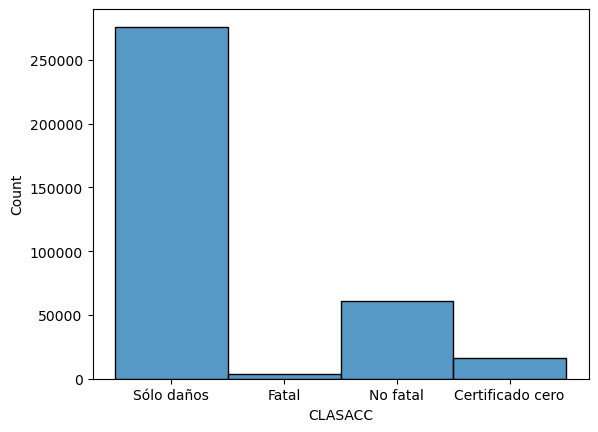

In [40]:
sns.histplot(data=df_initial_m, x='CLASACC')

En primera instancia, podemos observar que es una variable categórica fuertemente desbalanceada.

### 5. Variables predictoras

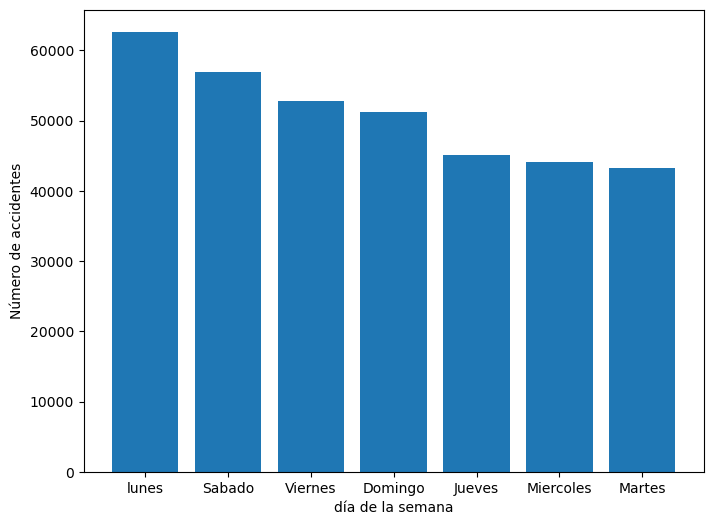

In [41]:
## Comportamiento dìa entre semana 
df_plot = df_initial['DIASEMANA'].value_counts().reset_index()
# Seleccionar datos
height = df_plot['DIASEMANA']
bars = df_plot['index']
y_pos = np.arange(len(bars))
plt.rcParams['figure.figsize'] = [8, 6]
# Crear Barras
plt.bar(y_pos, height)
# Crear nombres
plt.xticks(y_pos, bars)
# Mostrar Grafico
# figure size in inches
plt.xlabel("día de la semana")
plt.ylabel("Número de accidentes")
plt.show()

El sabado y viernes son los de mayor accidentalidad, es posible que se encuentren relacionados a los días de descanso.

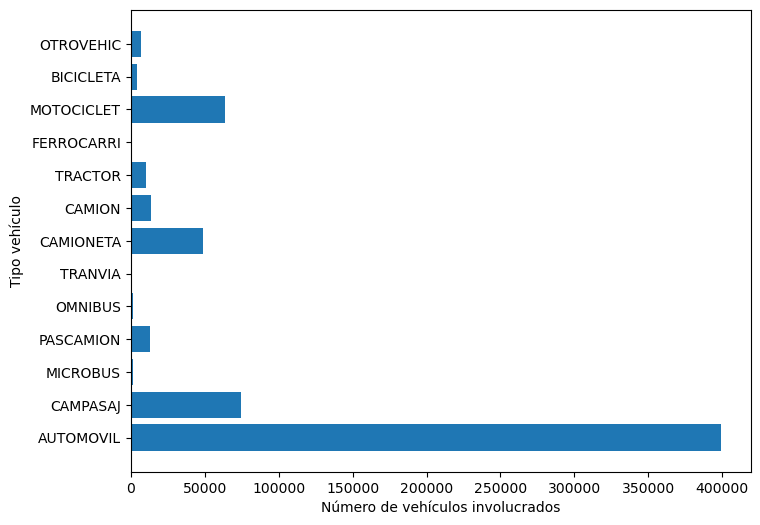

In [42]:
## Numero de tipos de vehiculos involucrados
df_plot = df_initial[['AUTOMOVIL', 'CAMPASAJ', 'MICROBUS',
       'PASCAMION', 'OMNIBUS', 'TRANVIA', 'CAMIONETA', 'CAMION', 'TRACTOR',
       'FERROCARRI', 'MOTOCICLET', 'BICICLETA', 'OTROVEHIC']].sum().reset_index()
# Seleccionar datos
height = df_plot[0]
bars = df_plot['index']
y_pos = np.arange(len(bars))
plt.rcParams['figure.figsize'] = [8, 6]
# Crear Barras
plt.barh(y_pos, height)
# Crear nombres
plt.yticks(y_pos, bars)
# Mostrar Grafico
# figure size in inches
plt.xlabel("Número de vehículos involucrados")
plt.ylabel("Tipo vehículo")
plt.show()

El vehículo tipo automóvil seguido por las camionetas de pasajeros y motocicletas son los vehículos que más están involucrados en accidentes.

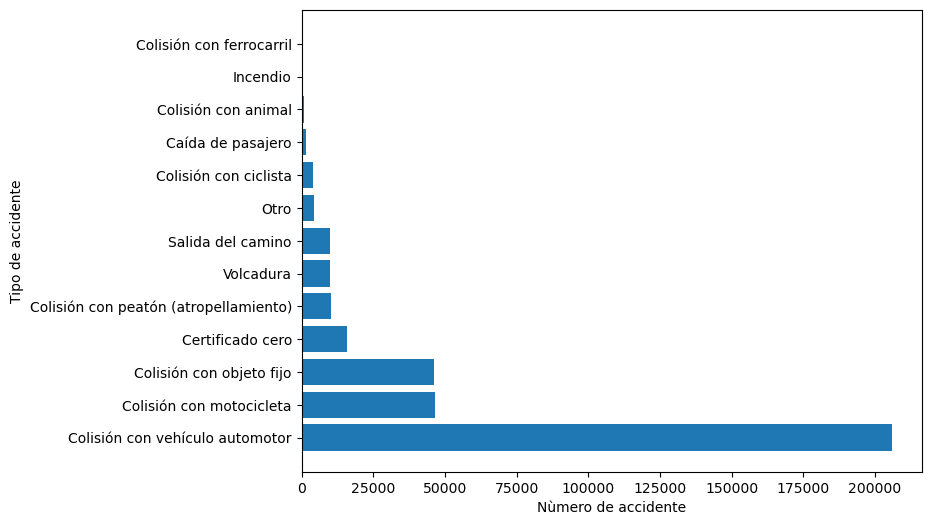

In [43]:
## Comportamiento dìa entre semana 
df_plot = df_initial['TIPACCID'].value_counts().reset_index()
# Seleccionar datos
height = df_plot['TIPACCID']
bars = df_plot['index']
y_pos = np.arange(len(bars))
plt.rcParams['figure.figsize'] = [8, 6]
# Crear Barras
plt.barh(y_pos, height)
# Crear nombres
plt.yticks(y_pos, bars)
# Mostrar Grafico
# figure size in inches
plt.xlabel("Nùmero de accidente")
plt.ylabel("Tipo de accidente")
plt.show()

El tipo de accidente con mayor cantidad es la 'Colisión con vehículo automotor' y el accidente de menor frecuencia es 'Colisión con ferrocarril'.

<AxesSubplot:xlabel='SEXO', ylabel='ID_EDAD'>

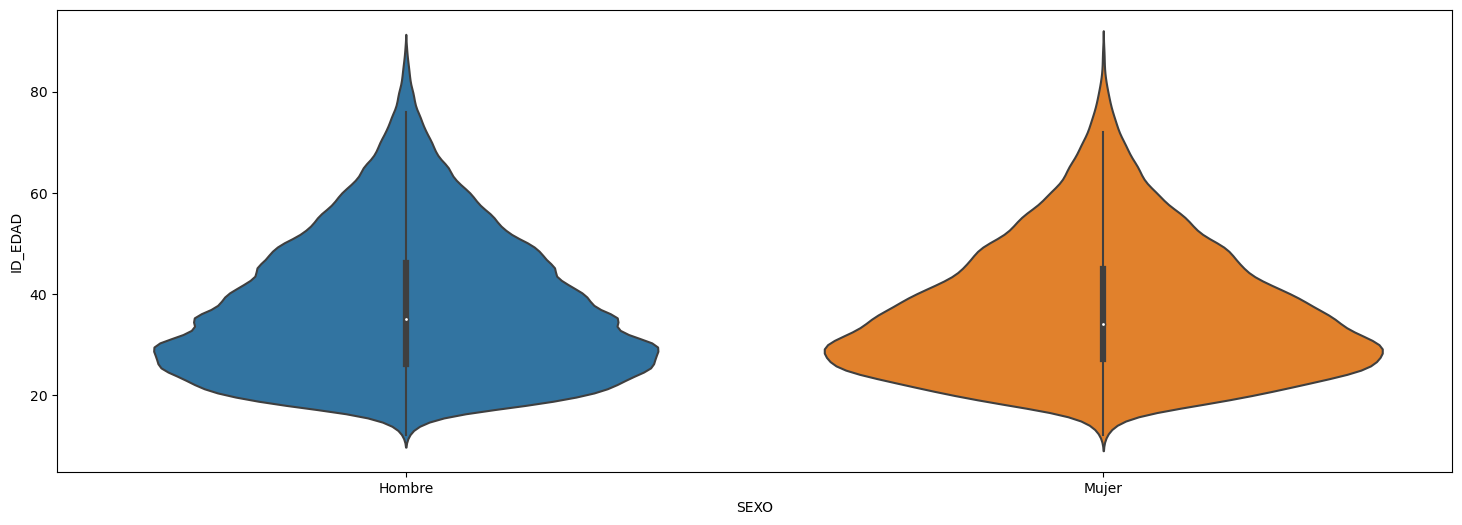

In [44]:
df = df_initial[['SEXO','ID_EDAD']]
df = df_initial[(df_initial['ID_EDAD']<90)&(df_initial['ID_EDAD']>10)]
plt.rcParams['figure.figsize'] = [18, 6]
# plot
sns.violinplot(x=df["SEXO"], y=df["ID_EDAD"])

La mediana tanto para hombres como para mujeres se encuentra en los 35 años de edad, donde se observa una alta distribución de la edad de los conductores entre los 23 y 30 años.

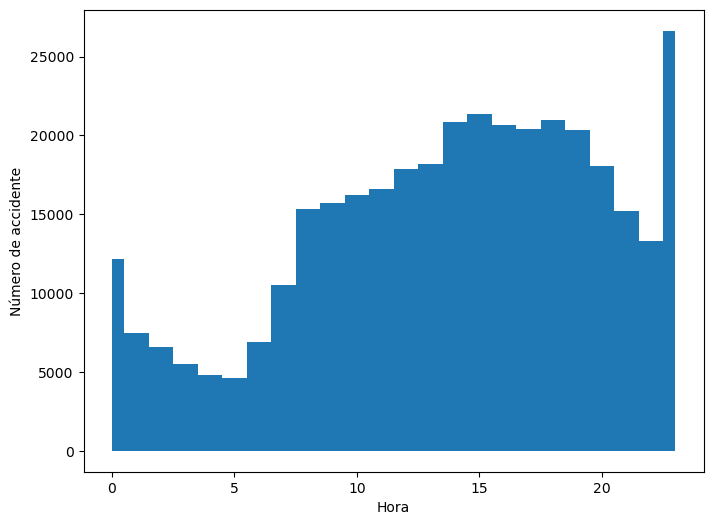

In [45]:
## Comportamiento dìa entre semana 
df_plot = df_initial['ID_HORA'].value_counts().reset_index()
#Ordenar Hora
df_plot= df_plot.sort_values(by=['index'])
# Seleccionar datos
x=range(0,24)
y=df_plot['ID_HORA']
# Area plot
plt.rcParams['figure.figsize'] = [8, 6]
# Crear diagrama
plt.fill_between(x, y,step='mid')
# Mostrar Grafico
# figure size in inches
plt.xlabel("Hora")
plt.ylabel("Número de accidente")
plt.show()

Se obseva un pico en horas de la tarde entre las 13 y las 16 Horas, siendo la hora de menor accidentalidad las 5 de la mañana.

In [35]:
df_initial_mcopy = df_initial_m.copy()

### 6. Matriz de correlación

Ahora, construiremos una matriz de correlación, para lo que es necesario transformar todas las variables categóricas a dummies. Para ello, eliminaremos algunas variables que contextualmente tendran una fuerte relación con 'CLASACC' como los muertos y heridos.

In [51]:
df_initial_m = df_initial_m.drop([i for i in list(df_initial_m.columns) if "MUERTO" in i],axis=1)
df_initial_m = df_initial_m.drop([i for i in list(df_initial_m.columns) if "HERIDO" in i],axis=1)

Ahora cambiamos la variable objetivo para que sea dummie.

In [52]:
df_initial_m.CLASACC = df_initial_m.CLASACC.replace({'Sólo daños':'No fatal'})

In [53]:
df_initial_m.CLASACC = df_initial_m.CLASACC.replace({'fatal':1,'No fatal':0,'Fatal':1})

Finalmente, creamos las variables dummies y la matriz de correlación.

In [54]:
#Transformación de variables dummies
desc_cat = crear_calidad(df_initial_m)
desc_cat = desc_cat[desc_cat['Tipo de Columna']=='object']
df_initial_cat = df_initial_m[desc_cat.Columna.unique()]

In [55]:
#Todas las variables categoricas las convertimos en variables dummies y las adjuntamos en una lista
todas_dummies = []
for i in list(df_initial_cat.columns):
    x = pd.get_dummies(df_initial_cat[i])
    x = x[pareto_entry(i,df_initial_cat)[i].unique()]
    x = x.iloc[:,:-1]
    column_index = []
    for j in list(x.columns):
        column_index.append((i,j))
    column_tuple = list(column_index)
    y = pd.DataFrame(x.values,index=x.index,columns=column_tuple)
    todas_dummies.append(y)

df_initial_dummies = pd.concat([i for i in todas_dummies], axis=1)
df_initial_dummies.head(2)

,"(DIASEMANA, lunes)","(DIASEMANA, Sabado)","(DIASEMANA, Viernes)","(DIASEMANA, Domingo)","(DIASEMANA, Jueves)","(DIASEMANA, Miercoles)","(URBANA, Accidente en intersección)","(URBANA, Sin accidente en esta zona)","(SUBURBANA, Sin accidente en esta zona)","(SUBURBANA, Accidente en carretera estatal)",...,"(ALIENTO, Se ignora)","(ALIENTO, Sí)","(CINTURON, Se ignora)","(CINTURON, Sí)","(CINTURON, No)","(CLASACC, 0)","(CLASACC, Certificado cero)","(Clasificacion, Ciudad Grande)","(Clasificacion, Ciudad)","(Clasificacion, Municipio)"
0,0,0,1,0,0,0,1,0,1,0,...,0,1,1,0,0,1,0,1,0,0
1,0,0,1,0,0,0,1,0,1,0,...,0,0,1,0,0,1,0,1,0,0


In [56]:
desc_con = crear_calidad(df_initial_m)
desc_con = desc_con[desc_con['Tipo de Columna']=='int64']
df_initial_con = df_initial_m[desc_con.Columna.unique()]
#Unimos las columnas dummies a las columnas numericas
df_initial_final = df_initial_dummies.join(df_initial_con,how="inner")
#df_initial_final.columns

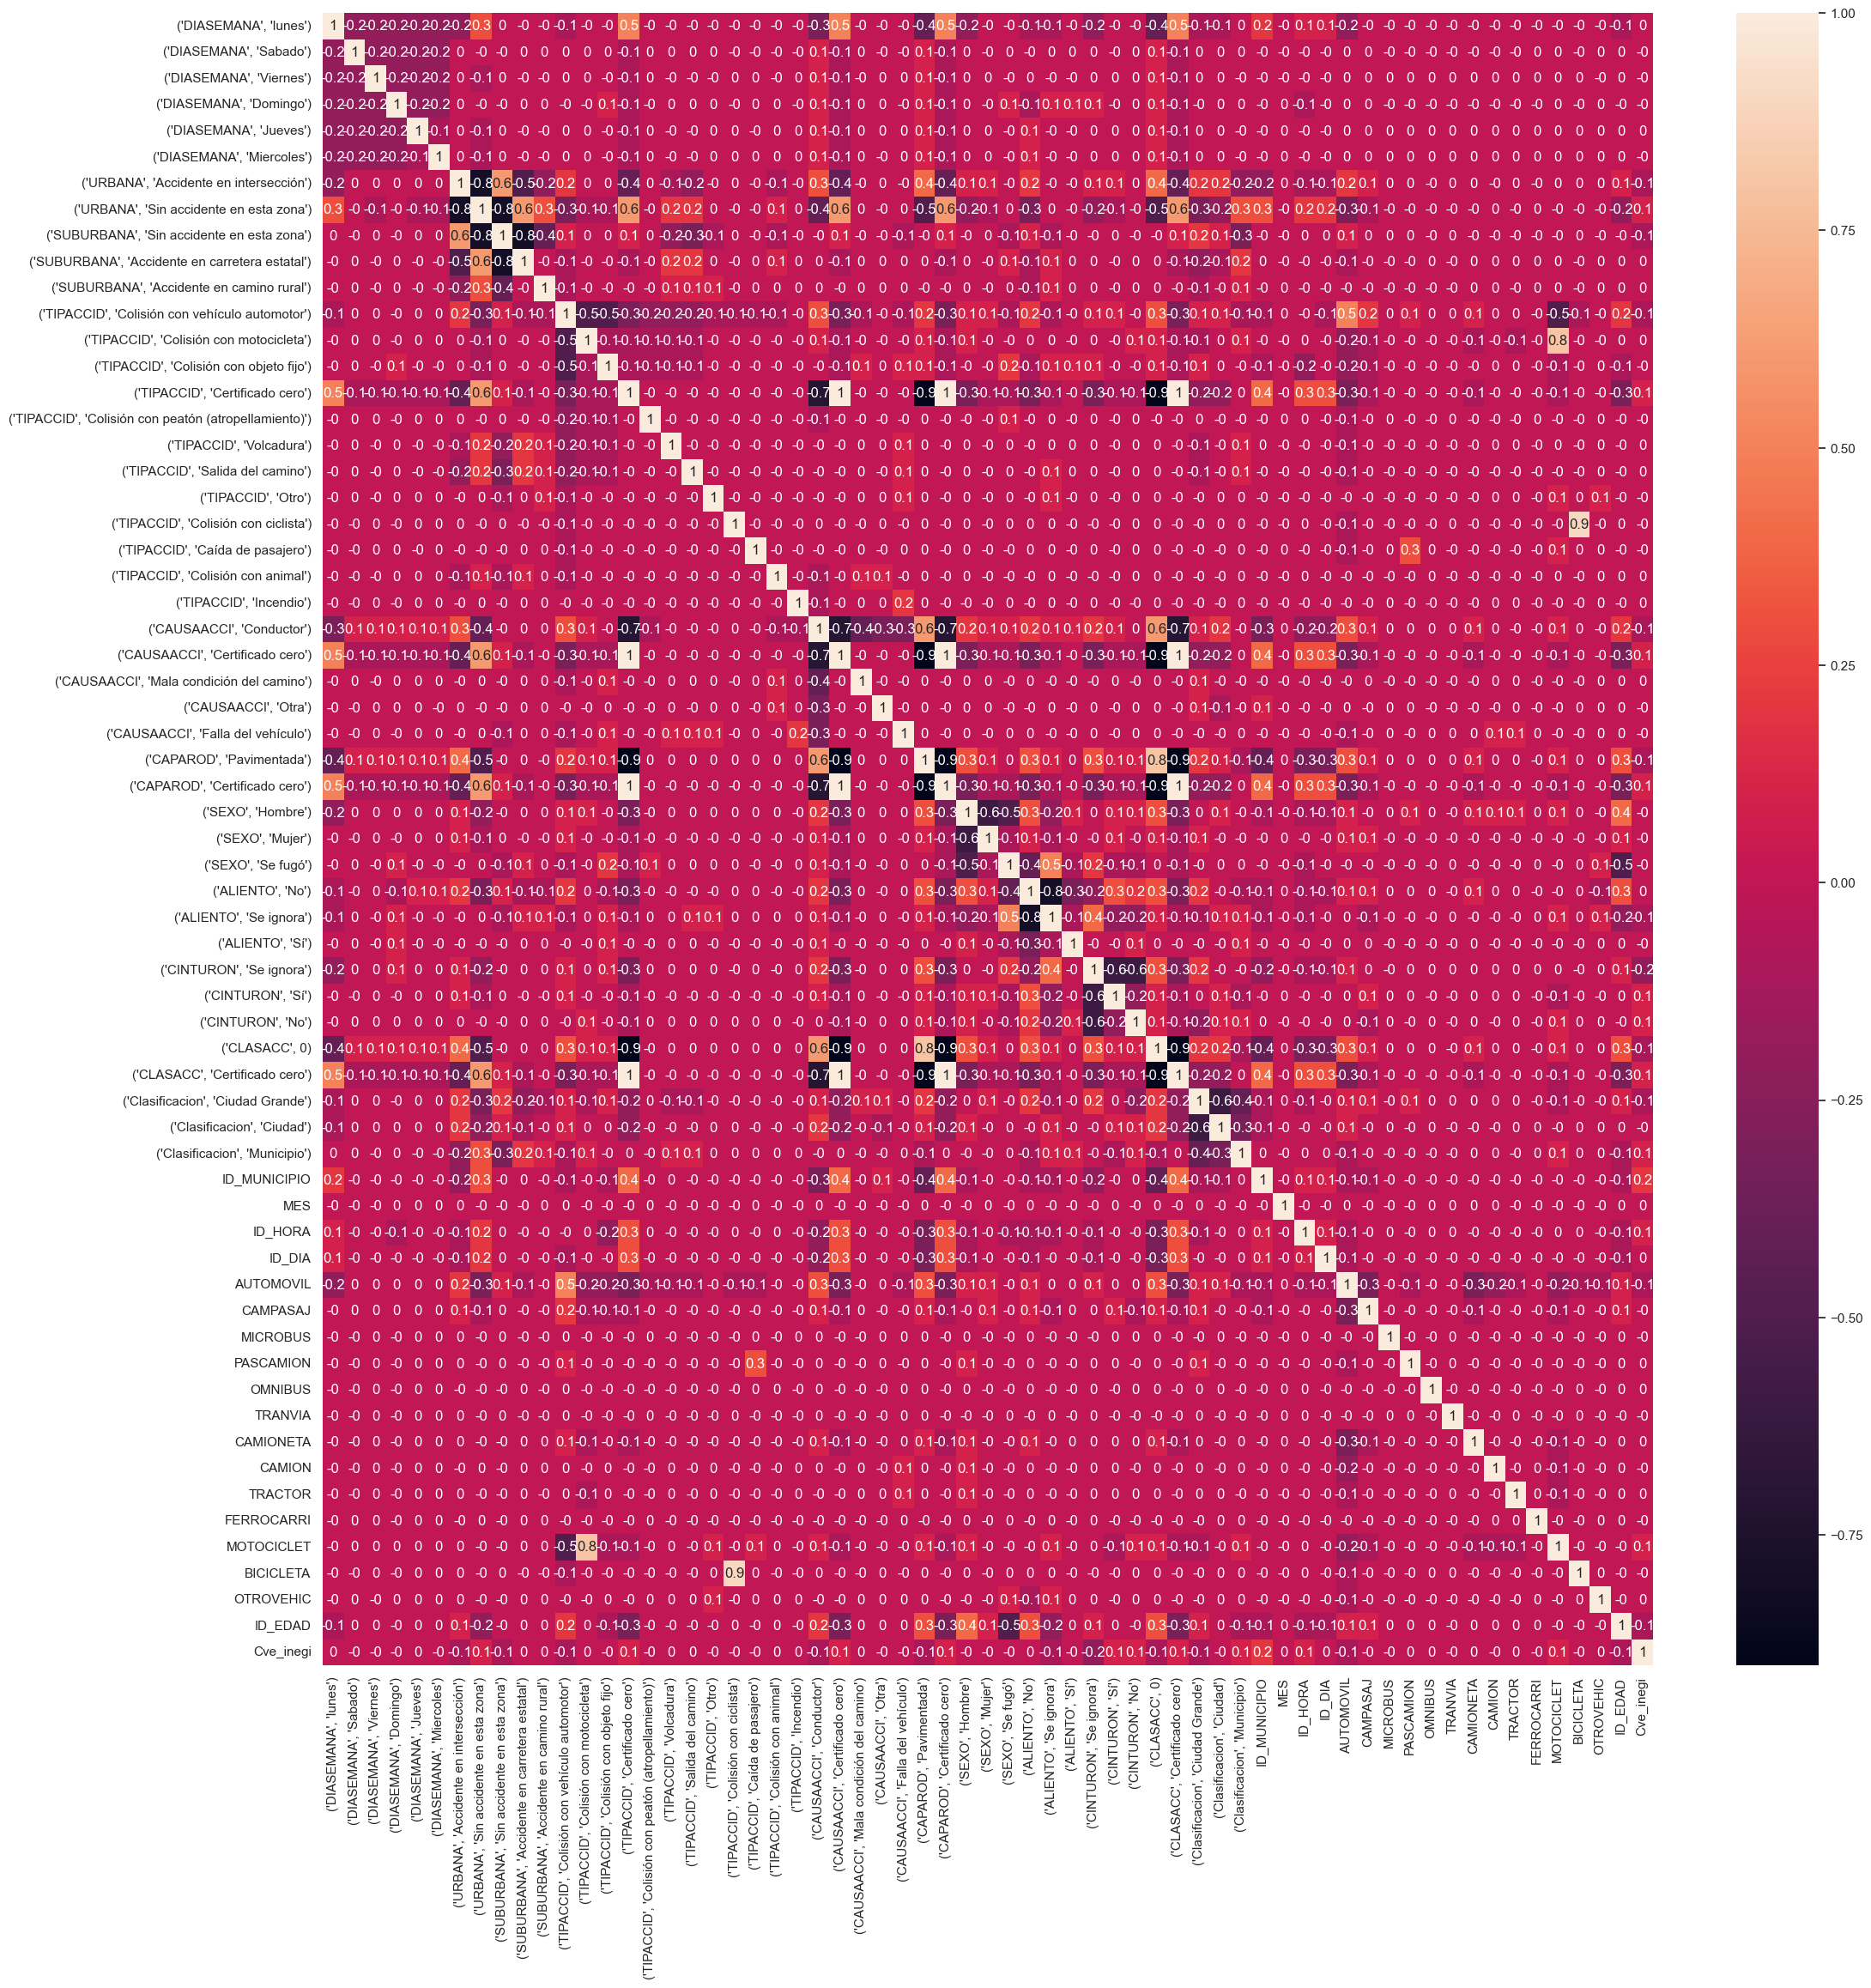

In [57]:
matrix_corr = pd.DataFrame(df_initial_final).corr().round(1)
sns.set(rc={'figure.figsize':(25,25)})
sns.heatmap(matrix_corr, annot=True)
plt.show()

Por ahora, no se observan correlaciones fuertes con la variable de respuesta 'CLASACC'.

In [19]:
df_initial.describe()

,ID_MUNICIPIO,MES,ID_HORA,ID_DIA,AUTOMOVIL,CAMPASAJ,MICROBUS,PASCAMION,OMNIBUS,TRANVIA,CAMIONETA,CAMION,TRACTOR,FERROCARRI,MOTOCICLET,BICICLETA,OTROVEHIC,ID_EDAD,CLASACC
count,340415.00000,340415.000000,340415.000000,340415.000000,340415.000000,340415.000000,340415.000000,340415.000000,340415.000000,340415.000000,340415.000000,340415.000000,340415.000000,340415.000000,340415.000000,340415.000000,340415.000000,340415.000000,340415.000000
mean,35.72515,6.699611,13.302416,15.588170,1.172983,0.218580,0.004257,0.037874,0.003807,0.000126,0.143842,0.040806,0.031124,0.000914,0.187324,0.013345,0.020234,40.571206,0.011307
std,41.96908,3.452799,6.083527,8.837548,0.756270,0.474127,0.066620,0.199280,0.062766,0.011238,0.386792,0.207069,0.181607,0.030309,0.419159,0.116326,0.147046,26.858078,0.105731
min,1.00000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,12.00000,4.000000,9.000000,8.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,25.000000,0.000000
50%,28.00000,7.000000,14.000000,16.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,35.000000,0.000000
75%,42.00000,10.000000,18.000000,23.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,51.000000,0.000000
max,570.00000,12.000000,23.000000,31.000000,9.000000,5.000000,3.000000,4.000000,3.000000,1.000000,8.000000,8.000000,9.000000,2.000000,7.000000,4.000000,7.000000,99.000000,1.000000


In [31]:
print(df_initial_final.loc[df_initial_final['CLASACC'] == 0, 'CLASACC'].count()/len(df_initial_final.index))
print(len(df_initial_final.index)-df_initial_final.loc[df_initial_final['CLASACC'] == 0, 'CLASACC'].count())

0.9886932126962678
3849


El **98,89%** de los accidentes no tienen victimas fatales en total hay registro de **3.849** accidentes con victimas fatales en 2021. 